# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
fraud_detection = pd.read_csv("../../PS_20174392719_1491204439457_log.csv")

In [3]:
len(fraud_detection.loc[fraud_detection["isFraud"]==1])

8213

In [4]:
fraud_detection.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
fraud_detection.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

### What is the distribution of the outcome? 

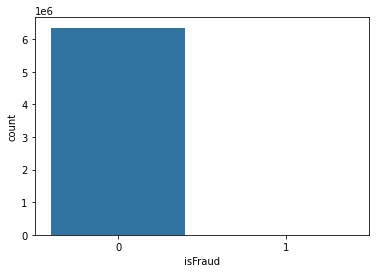

In [6]:
# Your response here
sns.countplot(fraud_detection["isFraud"])

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [21]:
# Your code here
isfraud = fraud_detection.loc[fraud_detection["isFraud"]==1]
isnotfraud = fraud_detection.loc[fraud_detection["isFraud"]==0].sample(n=len(isfraud))
fraud_balanced = pd.concat([isfraud,isnotfraud])

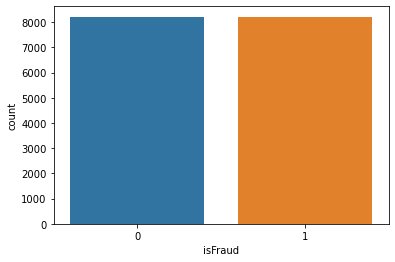

In [23]:
sns.countplot(fraud_balanced.isFraud)

In [25]:
fraud_balanced.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.149637,0.077618,-0.016587,-0.003402,0.031771,0.322013,0.037336
amount,0.149637,1.000000,0.634104,0.117819,0.019898,0.285973,0.346537,0.067604
oldbalanceOrg,0.077618,0.634104,1.000000,0.829686,0.020420,0.131966,0.116869,0.061973
newbalanceOrig,-0.016587,0.117819,0.829686,1.000000,0.055457,0.017281,-0.137741,0.088087
oldbalanceDest,-0.003402,0.019898,0.020420,0.055457,1.000000,0.918085,-0.086660,-0.007970
newbalanceDest,0.031771,0.285973,0.131966,0.017281,0.918085,1.000000,0.008116,-0.010671
isFraud,0.322013,0.346537,0.116869,-0.137741,-0.086660,0.008116,1.000000,0.031225
isFlaggedFraud,0.037336,0.067604,0.061973,0.088087,-0.007970,-0.010671,0.031225,1.000000


In [28]:
fraud_balanced.drop(["nameOrig","nameDest"], axis=1, inplace=True)

In [33]:
fraud_balanced

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,2806.00,0.00,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,2806.00,0.00,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,20128.00,0.00,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...
5872092,403,CASH_OUT,134118.05,244.00,0.00,8152.72,142270.78,0,0
5795174,401,CASH_IN,200745.83,2030975.77,2231721.60,2093685.06,1892939.23,0,0
3838178,282,PAYMENT,6714.39,163293.15,156578.75,0.00,0.00,0,0
696667,36,CASH_IN,115005.73,21308.00,136313.73,3530727.42,3415721.68,0,0


In [34]:
fraud_balanced["type"].value_counts()

CASH_OUT    6937
TRANSFER    4789
PAYMENT     2829
CASH_IN     1818
DEBIT         53
Name: type, dtype: int64

In [37]:
fraud_balanced_dummies = pd.get_dummies(fraud_balanced)
fraud_balanced_dummies

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0
251,1,2806.00,2806.00,0.00,0.00,0.00,1,0,0,0,0,0,1
252,1,2806.00,2806.00,0.00,26202.00,0.00,1,0,0,1,0,0,0
680,1,20128.00,20128.00,0.00,0.00,0.00,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5872092,403,134118.05,244.00,0.00,8152.72,142270.78,0,0,0,1,0,0,0
5795174,401,200745.83,2030975.77,2231721.60,2093685.06,1892939.23,0,0,1,0,0,0,0
3838178,282,6714.39,163293.15,156578.75,0.00,0.00,0,0,0,0,0,1,0
696667,36,115005.73,21308.00,136313.73,3530727.42,3415721.68,0,0,1,0,0,0,0


In [38]:
fraud_balanced_dummies.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
step,1.000000,0.149637,0.077618,-0.016587,-0.003402,0.031771,0.322013,0.037336,-0.098867,0.038544,-0.020137,-0.151260,0.154539
amount,0.149637,1.000000,0.634104,0.117819,0.019898,0.285973,0.346537,0.067604,-0.122947,0.051158,-0.024924,-0.197588,0.196539
oldbalanceOrg,0.077618,0.634104,1.000000,0.829686,0.020420,0.131966,0.116869,0.061973,0.268754,-0.099408,-0.019801,-0.165235,0.062259
newbalanceOrig,-0.016587,0.117819,0.829686,1.000000,0.055457,0.017281,-0.137741,0.088087,0.465808,-0.179266,-0.009619,-0.086070,-0.054021
oldbalanceDest,-0.003402,0.019898,0.020420,0.055457,1.000000,0.918085,-0.086660,-0.007970,0.088921,0.108732,0.003795,-0.116421,-0.083306
newbalanceDest,0.031771,0.285973,0.131966,0.017281,0.918085,1.000000,0.008116,-0.010671,0.025659,0.217253,-0.003250,-0.155880,-0.123915
isFraud,0.322013,0.346537,0.116869,-0.137741,-0.086660,0.008116,1.000000,0.031225,-0.352778,0.159615,-0.056895,-0.456137,0.456115
isFlaggedFraud,0.037336,0.067604,0.061973,0.088087,-0.007970,-0.010671,0.031225,1.000000,-0.011016,-0.026698,-0.001777,-0.014243,0.048675
type_CASH_IN,-0.098867,-0.122947,0.268754,0.465808,0.088921,0.025659,-0.352778,-0.011016,1.000000,-0.301632,-0.020071,-0.160915,-0.226310
type_CASH_OUT,0.038544,0.051158,-0.099408,-0.179266,0.108732,0.217253,0.159615,-0.026698,-0.301632,1.000000,-0.048646,-0.390005,-0.548501


### Run a logisitc regression classifier and evaluate its accuracy.

In [51]:
# Your code here
from sklearn.model_selection import train_test_split

X = fraud_balanced_dummies.drop(["isFraud"], axis=1)
y = fraud_balanced_dummies["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [57]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression().fit(X_train, y_train)

In [74]:
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_lr_train_pred = model_lr.predict(X_train) 
y_lr_test_pred = model_lr.predict(X_test)

r2_lr_train = r2_score(y_train, y_lr_train_pred)
cm_lr_train = confusion_matrix(y_train, y_lr_train_pred)
acc_lr_train = accuracy_score(y_train, y_lr_train_pred)

r2_lr_test = r2_score(y_test, y_lr_test_pred)
cm_lr_test = confusion_matrix(y_test, y_lr_test_pred)
acc_lr_test = accuracy_score(y_test, y_lr_test_pred)

print("r2 score:", r2_lr_train)
print("Confusion matrix:\n", cm_lr_train)
print("Accuracy score:", acc_lr_train)

print("r2 score:",r2_lr_test)
print("Confusion matrix:\n",cm_lr_test)
print("Accuracy score:",acc_lr_test)

r2 score: 0.6121756616502335
Confusion matrix:
 [[5965  615]
 [ 659 5901]]
Accuracy score: 0.9030441400304414
r2 score: 0.6262795214698063
Confusion matrix:
 [[1494  139]
 [ 168 1485]]
Accuracy score: 0.9065733414485697


### Now pick a model of your choice and evaluate its accuracy.

In [67]:
# Your code here
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

In [75]:
y_knn_train_pred = model_knn.predict(X_train) 
y_knn_test_pred = model_knn.predict(X_test)

r2_knn_train = r2_score(y_train, y_knn_train_pred)
cm_knn_train = confusion_matrix(y_train, y_knn_train_pred)
acc_knn_train = accuracy_score(y_train, y_knn_train_pred)

r2_knn_test = r2_score(y_test, y_knn_test_pred)
cm_knn_test = confusion_matrix(y_test, y_knn_test_pred)
acc_knn_test = accuracy_score(y_test, y_knn_test_pred)

print("r2 score:",r2_knn_train)
print("Confusion matrix:\n",cm_knn_train)
print("Accuracy score:",acc_knn_train)

print("r2 score:",r2_knn_test)
print("Confusion matrix:\n",cm_knn_test)
print("Accuracy score:",acc_knn_test)

r2 score: 0.9089800022240344
Confusion matrix:
 [[6375  205]
 [  94 6466]]
Accuracy score: 0.9772450532724505
r2 score: 0.8441816897333394
Confusion matrix:
 [[1548   85]
 [  43 1610]]
Accuracy score: 0.9610468654899574


In [76]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression().fit(X_train, y_train)

In [91]:
y_lin_train_pred = model_linear.predict(X_train) 
y_lin_test_pred = model_linear.predict(X_test)

r2_lin_train = r2_score(y_train, y_lin_train_pred)
r2_lin_train

0.5607090713856286

### Which model worked better and how do you know?

In [10]:
# Your response here
# Knn worked better, as it has less false negatives and false positives and it has a greater accuracy score.

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.